In [1]:
import earthaccess
import geopandas as gpd
import h5py
import numpy as np
import pandas as pd
import pygmt
import pystac_client
import rioxarray  # noqa: F401
import shapely.geometry
import stackstac
#import torch
import tqdm

In [2]:
earthaccess.login()

Enter your Earthdata Login username:  Jehayes
Enter your Earthdata password:  ········


In [3]:
GEDI_results= earthaccess.search_data(
    short_name='GEDI02_B',
    version='002',
    cloud_hosted=True,
    bounding_box=(-121.83183686310275, 39.251634434878014, -120.00653085351905, 40.2087274330508),
    temporal=("2019-08-01", "2019-09-01"),
    count=3
)

In [4]:
GEDI_results

[Collection: {'ShortName': 'GEDI02_B', 'Version': '002'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': -158.6015651135, 'Latitude': -0.0100300309}, {'Longitude': -140.539844646, 'Latitude': 23.3566009965}, {'Longitude': -137.8749561776, 'Latitude': 26.2013941876}, {'Longitude': -135.0681660582, 'Latitude': 28.9826371402}, {'Longitude': -132.0968864286, 'Latitude': 31.6894485361}, {'Longitude': -128.9338646389, 'Latitude': 34.3091107961}, {'Longitude': -125.5598770797, 'Latitude': 36.8259912001}, {'Longitude': -121.9435288734, 'Latitude': 39.2241059194}, {'Longitude': -118.0626455903, 'Latitude': 41.4824080213}, {'Longitude': -113.9006376509, 'Latitude': 43.5846280408}, {'Longitude': -109.4342894506, 'Latitude': 45.5025714683}, {'Longitude': -104.6560518645, 'Latitude': 47.2127155124}, {'Longitude': -99.5683380437, 'Latitude': 48.6878240741}, {'Longitude': -94.1876160397, 'Latitude': 49.9021379921}, {'Longitude': -88.55

In [5]:
import json
import re
import geopandas as gpd
from shapely.geometry import Polygon
# Assume that DataGranule is a class and input_list contains instances of this class
class DataGranule:
    def __init__(self, data):
        self.data = data

    def __str__(self):
        return self.data
        # Convert each DataGranule object to its string representation
input_str = ''.join(str(item) for item in GEDI_results)
# Extract the JSON-like portion of the string using regex
match = re.search(r"\[\{'Longitude':.*?\}\]", input_str)
# If the pattern is found, proceed to convert it into a list of dictionaries
if match:
    spatial_coverage_str = match.group(0)
    # Convert the string to a Python list of dictionaries
    spatial_coverage = json.loads(spatial_coverage_str.replace("'", '"'))
# Now spatial_coverage contains the list of dictionaries with Longitude and Latitude
print(spatial_coverage)
# Convert to a list of tuples (Longitude, Latitude)
coords = [(point['Longitude'], point['Latitude']) for point in spatial_coverage]
# Create a Polygon object
polygon = Polygon(coords)
# Create a GeoDataFrame
GEDI_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[polygon])


# Create polygon from user-inputted bounding box
bbox = (-121.83183686310275, 39.251634434878014, -120.00653085351905, 40.2087274330508)
bbox_polygon = Polygon([(bbox[0], bbox[1]), (bbox[0], bbox[3]), 
                   (bbox[2], bbox[3]), (bbox[2], bbox[1])])
bbox_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[bbox_polygon])

GEDI_clip_poly = gpd.clip(GEDI_gdf, bbox_gdf)
print(GEDI_clip_poly.iloc[0].geometry)

[{'Longitude': -158.6015651135, 'Latitude': -0.0100300309}, {'Longitude': -140.539844646, 'Latitude': 23.3566009965}, {'Longitude': -137.8749561776, 'Latitude': 26.2013941876}, {'Longitude': -135.0681660582, 'Latitude': 28.9826371402}, {'Longitude': -132.0968864286, 'Latitude': 31.6894485361}, {'Longitude': -128.9338646389, 'Latitude': 34.3091107961}, {'Longitude': -125.5598770797, 'Latitude': 36.8259912001}, {'Longitude': -121.9435288734, 'Latitude': 39.2241059194}, {'Longitude': -118.0626455903, 'Latitude': 41.4824080213}, {'Longitude': -113.9006376509, 'Latitude': 43.5846280408}, {'Longitude': -109.4342894506, 'Latitude': 45.5025714683}, {'Longitude': -104.6560518645, 'Latitude': 47.2127155124}, {'Longitude': -99.5683380437, 'Latitude': 48.6878240741}, {'Longitude': -94.1876160397, 'Latitude': 49.9021379921}, {'Longitude': -88.5541352731, 'Latitude': 50.8299319569}, {'Longitude': -82.7236016559, 'Latitude': 51.4511080992}, {'Longitude': -76.7710728305, 'Latitude': 51.7496376902}, {'

<Axes: >

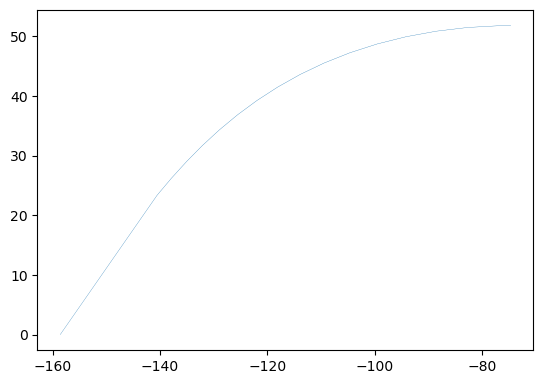

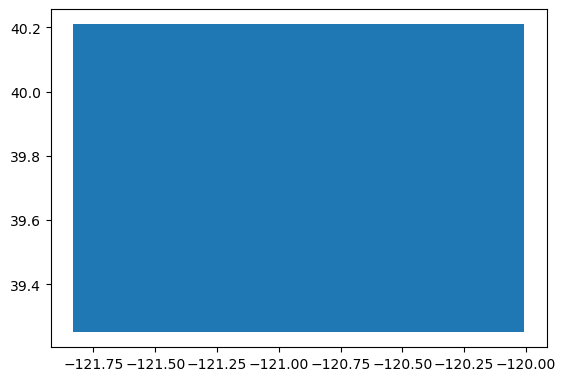

In [6]:
GEDI_gdf.plot()
bbox_gdf.plot()

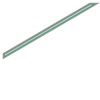

In [7]:
GEDI_clip_poly.iloc[0].geometry

In [11]:
geom = GEDI_clip_poly.iloc[0].geometry
geom.exterior.xy

(array('d', [-121.83183686310275, -121.83183686310275, -120.36021683143657, -120.25146067344878, -121.83183686310275]),
 array('d', [39.28909996411093, 39.35208436432354, 40.2087274330508, 40.2087274330508, 39.28909996411093]))

In [14]:
x_values = geom.boundary.xy[0].tolist()
y_values = geom.boundary.xy[1].tolist()

In [15]:
[(x, y) for x, y in zip(x_values, y_values)]

[(-121.83183686310275, 39.28909996411093),
 (-121.83183686310275, 39.35208436432354),
 (-120.36021683143657, 40.2087274330508),
 (-120.25146067344878, 40.2087274330508),
 (-121.83183686310275, 39.28909996411093)]

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
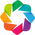

In [17]:
import icepyx as ipx
short_name = 'ATL08'
spatial_extent = [(x, y) for x, y in zip(x_values, y_values)]
date_range = ["2019-08-01", "2019-09-01"]
region = ipx.Query(short_name, spatial_extent, date_range)

In [18]:
region.avail_granules(ids=True)

[['ATL08_20190815210225_07450406_006_02.h5',
  'ATL08_20190819205407_08060406_006_02.h5',
  'ATL08_20190821083817_08290402_006_02.h5',
  'ATL08_20190825082958_08900402_006_02.h5']]

In [19]:
print(region.avail_granules(ids=True, cloud=True))
s3urls = region.avail_granules(ids=True, cloud=True)[1]

[['ATL08_20190815210225_07450406_006_02.h5', 'ATL08_20190819205407_08060406_006_02.h5', 'ATL08_20190821083817_08290402_006_02.h5', 'ATL08_20190825082958_08900402_006_02.h5'], ['s3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2019/08/15/ATL08_20190815210225_07450406_006_02.h5', 's3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2019/08/19/ATL08_20190819205407_08060406_006_02.h5', 's3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2019/08/21/ATL08_20190821083817_08290402_006_02.h5', 's3://nsidc-cumulus-prod-protected/ATLAS/ATL08/006/2019/08/25/ATL08_20190825082958_08900402_006_02.h5']]


In [25]:
#reader = ipx.Read(s3urls[0])
#reader
region.download_granules('/tmp/test_ATL08')
reader = ipx.Read('/tmp/test_ATL08')
reader

Total number of data order requests is  1  for  4  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000005738358
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
NSIDC returned these messages
['Granule 268773758 contained no data within the spatial and/or temporal '
 'subset constraints to be processed']
Beginning download of zipped output...
Data request 5000005738358 of  1  order(s) is downloaded.
Download complete


In [26]:
reader.vars.append(var_list=['h_canopy', 'latitude', 'longitude'])

In [31]:
ds = reader.load()

In [32]:
ds[0]

<xarray.Dataset> Size: 35kB
Dimensions:              (gran_idx: 1, photon_idx: 381, spot: 6)
Coordinates:
  * gran_idx             (gran_idx) float64 8B 8.29e+04
  * photon_idx           (photon_idx) int64 3kB 0 1 2 3 4 ... 377 378 379 380
  * spot                 (spot) uint8 6B 1 2 3 4 5 6
    source_file          (gran_idx) <U65 260B '/tmp/test_ATL08/processed_ATL0...
    delta_time           (photon_idx) datetime64[ns] 3kB 2019-08-21T08:41:36....
Data variables:
    sc_orient            (gran_idx) int8 1B 0
    cycle_number         (gran_idx) int8 1B 4
    rgt                  (gran_idx, spot, photon_idx) float32 9kB 829.0 ... 8...
    atlas_sdp_gps_epoch  (gran_idx) datetime64[ns] 8B 2018-01-01T00:00:18
    data_start_utc       (gran_idx) datetime64[ns] 8B 2019-08-21T08:41:08.259497
    data_end_utc         (gran_idx) datetime64[ns] 8B 2019-08-21T08:46:32.654805
    latitude             (spot, gran_idx, photon_idx) float32 9kB 39.66 ... 3...
    longitude            (spot, gran_idx, photon_idx) float32 9kB -121.2 ... ...
    gt                   (gran_idx, spot) object 48B 'gt1l' 'gt1r' ... 'gt3r'
    h_canopy             (photon_idx) float32 2kB 36.72 38.03 ... 40.87 29.05
Attributes:
    data_product:  ATL08
    Description:   Contains data categorized as land at 100 meter intervals.
    data_rate:     Data are stored as aggregates of 100 meters.

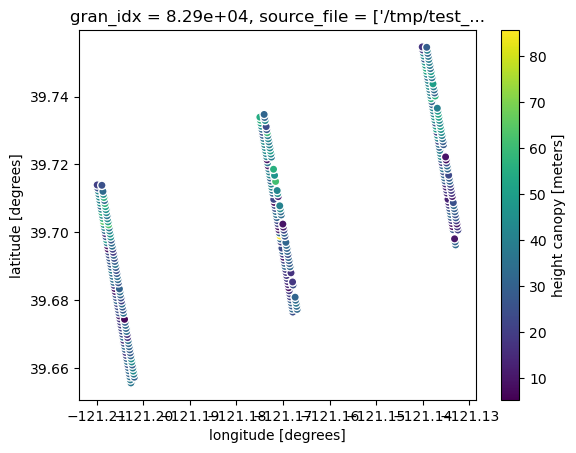

In [33]:
ds[0].plot.scatter(x="longitude", y="latitude", hue="h_canopy")